<h1>Analyzing OpenStreetMap Paris Road Network with PyG, NetworkX, and Graph Neural Networks</h1>

# Initialization

In [ ]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.0.0+cu118


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/MLNS/Final_Project/')

In [ ]:
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git


! pip install torch-geometric
! pip install ogb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 80.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 38.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 64.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-a08a9i0s
  Running command git clone --filter=blob:none --quiet https://github.com/py

# Imports

We are using paris-2046.graphml from https://dataverse.harvard.edu/file.xhtml?fileId=4287455&version=2.0 for our analysis.



In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch_geometric
from torch_geometric.loader import NeighborSampler
import torch.nn.functional as F

In [ ]:
paris = nx.readwrite.graphml.read_graphml('paris-2046.graphml')
print(paris)

MultiDiGraph with 131622 nodes and 287697 edges


# Graph Construction



GraphML is an XML-based file format for graphs. The GraphML file format results from the joint effort of the graph drawing community to define a common format for exchanging graph structure data. It uses an XML-based syntax and supports the entire range of possible graph structure constellations including directed, undirected, mixed graphs, hypergraphs, and application-specific attributes.

The graph consists of actual junctions found in the real world, and the connections between them represent sections of roads, with the direction of the edges indicating the flow of traffic.

The graph used is a MultiDiGraph, which allows for self-loops and multiple edges between nodes. However, there are instances of self-loops and parallel edges, which will be removed by using the nx.DiGraph constructor.

In [ ]:
paris = nx.DiGraph(paris)
print(paris)

DiGraph with 131622 nodes and 285191 edges



We visualize Paris network using upto a depth limit of 30 around a single node (with OSM Node ID '411256174')

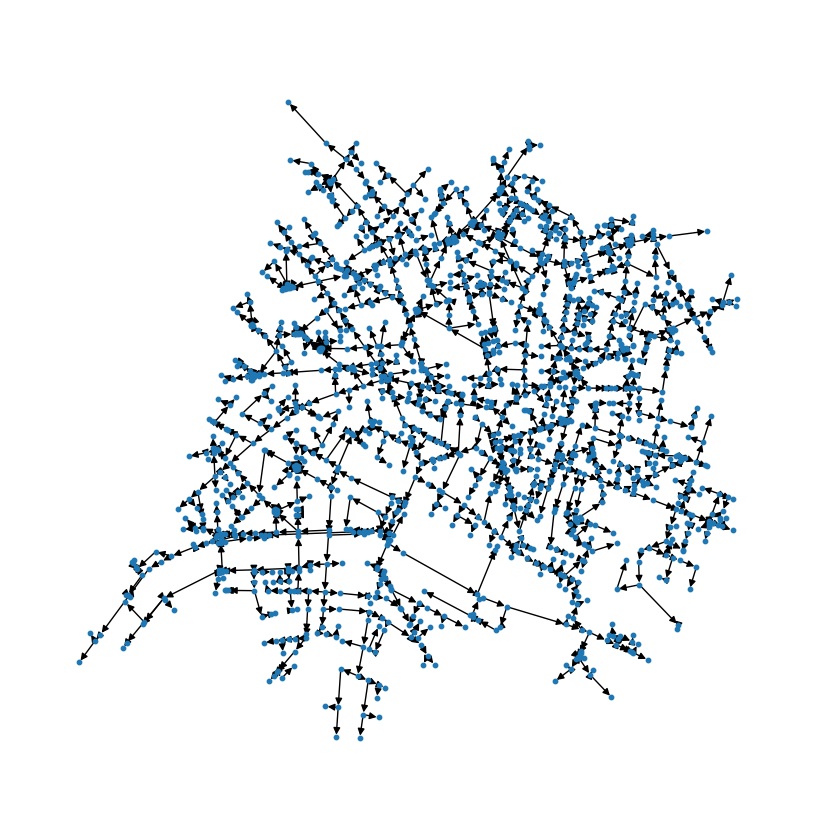

In [ ]:
edges_from_bfs = nx.algorithms.traversal.bfs_edges(paris, '29604238', depth_limit=30)
subgraph = paris.edge_subgraph(edges_from_bfs)

# Mapping to the latitudes, longitudes on the map
latitudes = [(u, y) for (u, y) in nx.get_node_attributes(subgraph, 'y').items()]
longitudes = [(u, x) for (u, x) in nx.get_node_attributes(subgraph, 'x').items()]

# Switching to pos values to process the coordinates
pos = {u:(float(x),float(y)) for ((u,y), (u,x)) in zip(latitudes, longitudes)}
plt.figure(1, figsize=(8,8)) 
nx.draw(subgraph, pos=pos, node_size=10)
plt.show()

In [ ]:
latitude = paris.nodes['29604238']['y'] 
longitude = paris.nodes['29604238']['x']
print("lat,lng is: {},{}".format(latitude, longitude))

lat,lng is: 48.8721849,2.32987


Looking up the coordinates on Google Maps leads us to the intersection of the [Palais Garnier](https://www.google.com/maps/place/48°52'19.9%22N+2°19'47.5%22E/@48.8721849,2.3272951,17z/data=!3m1!4b1!4m4!3m3!8m2!3d48.8721849!4d2.32987) in Paris! 

**Features of the Dataset**


Existing features in the dataset can be looked up at [OpenStreetMap Wiki](https://wiki.openstreetmap.org/wiki/Main_Page). We will look at the important features and derive more from it to analyse the graph.

In [ ]:
# Node (Intersection) Features
all_node_keys = list(list(paris.nodes[n].keys()) for n in paris.nodes())
all_node_keys = set(np.concatenate(all_node_keys).flat)
all_node_keys

{'elevation',
 'elevation_aster',
 'elevation_srtm',
 'highway',
 'ref',
 'street_count',
 'x',
 'y'}

In [ ]:
# Edge (Road Segment) Features
all_edge_keys = list(list(paris.edges[e].keys()) for e in paris.edges())
all_edge_keys = set(np.concatenate(all_edge_keys).flat)
all_edge_keys

{'access',
 'area',
 'bridge',
 'est_width',
 'geometry',
 'grade',
 'grade_abs',
 'highway',
 'junction',
 'lanes',
 'length',
 'maxspeed',
 'name',
 'oneway',
 'osmid',
 'ref',
 'service',
 'tunnel',
 'width'}

## Understanding the Node Features

We extract node statistics like average degree and closeness centrality to understand the graph better.

The code calculates the average degree of nodes in the Paris graph. The average degree of a node in a graph is the average number of edges connected to the node. We use **(total number of edges)/ (total number of nodes)** to compute this. In the context of a transportation network, this can be a useful metric to determine the overall connectivity of the network.


In [ ]:
# Average Degree
paris.number_of_edges() / paris.number_of_nodes()

2.1667426418076006

(array([2.7500e+02, 3.3254e+04, 0.0000e+00, 4.8476e+04, 0.0000e+00,
        4.3655e+04, 5.8040e+03, 0.0000e+00, 1.4400e+02, 1.4000e+01]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

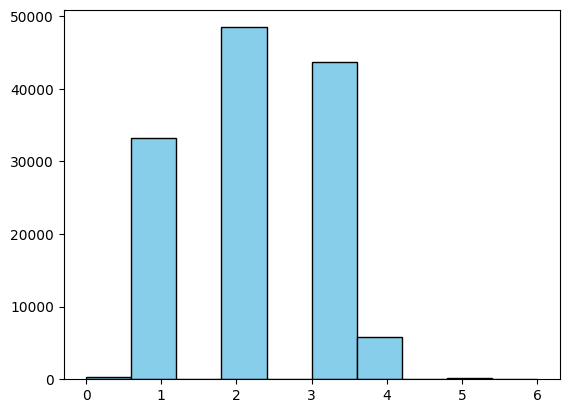

In [ ]:
# Histogram of out degree.
out_degrees = [v for (k,v) in paris.out_degree]
plt.hist(out_degrees, color = 'skyblue', lw=1, ec="black")

[Centrality measurements](http://web.stanford.edu/class/cs224w/slides/) are used to identify important nodes within a network. They help us to understand the structure and function of the network, as well as the importance of different nodes in the network. Centrality measures can help us to answer questions such as:

*   Which nodes are the most important in the network?
*   Which nodes are the best connected or most influential?  

There are many different types of centrality measures, each capturing a different aspect of importance in the network. For example, degree centrality measures the number of connections a node has, while betweenness centrality measures how often a node lies on the shortest path between other pairs of nodes. By using centrality measures, we can gain insights into the underlying structure and dynamics of the network, and use this knowledge to make predictions or design interventions.

**Betweenness Centrality**

Betweenness centrality is a measure of the importance of a node in a graph. It quantifies the number of shortest paths that pass through a node, compared to the total number of shortest paths in the graph. Nodes with high betweenness centrality are important because they act as bridges or bottlenecks, allowing communication and flow of information between different parts of the graph. This measure can be used to identify critical nodes in a network that, if removed, would have a large impact on the connectivity and efficiency of the graph. 

Here, we are calculating on a subset of graph due to huge size!

In [ ]:
import random

# Define subset size
subset_size = 500

# Compute degree centrality for all nodes in the graph
degree_centrality = nx.degree_centrality(paris)

# Select nodes with highest degree centrality
sorted_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)
subset_nodes = sorted_nodes[:subset_size]

# Compute betweenness centrality for the subset and their neighbors
betweenness_centrality = nx.algorithms.centrality.betweenness_centrality_subset(paris, sources=subset_nodes, targets=[], normalized=True)

# Find the node with highest betweenness centrality
betweenness_max_node = max(betweenness_centrality, key=betweenness_centrality.get)

# Print coordinates of the node with highest betweenness centrality
print("Betweeness Centrality intersection is at: {},{}".format(paris.nodes[betweenness_max_node]['y'],
                                                               paris.nodes[betweenness_max_node]['x']))


Betweeness Centrality intersection is at: 48.8840815,2.4635493


**Closeness Centrality**

Closeness centrality measures how close a node is to all other nodes in the network. A node with high closeness centrality is located close to most of the other nodes in the network, making it an important point of connection. In the context of lane prediction in Paris, nodes with high closeness centrality can be potential candidates for the expansion of new lanes or the optimization of existing lanes to improve connectivity and reduce travel time.

In [ ]:
import random

# Define subset size
subset_size = 500

# Compute degree centrality for all nodes in the graph
degree_centrality = nx.degree_centrality(paris)

# Select nodes with highest degree centrality
sorted_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)
subset_nodes = sorted_nodes[:subset_size]

# Compute closeness centrality for the subset of nodes
closeness_centrality = nx.algorithms.centrality.closeness_centrality(paris.subgraph(subset_nodes))

# Find the node in the subset with highest closeness centrality
closeness_max_node = max(subset_nodes, key=closeness_centrality.get)

# Print coordinates of the node with highest closeness centrality
print("Closeness Centrality intersection is at: {},{}".format(paris.nodes[closeness_max_node]['y'],
                                                               paris.nodes[closeness_max_node]['x']))


Closeness Centrality intersection is at: 48.6801412,2.1822906


# Feature Selection


In [ ]:
# A helper function to count the number of edges with a particular feature present.
def countEdgesWithFeature(feature_dict, feature_key):
  count = 0
  for k,v in feature_dict.items():
    if feature_key in v:
      count += 1
  return count

In [ ]:
# Total number of edges
E = len(paris.edges())
print(E)

285191


Counting the features of each edge helps us understand the rate of missing features.

In [ ]:
for attribute_name in all_edge_keys:
  count = countEdgesWithFeature(paris.edges(), attribute_name)
  print("{}: {} (Percentage: {:.1%})".format(attribute_name, count, count/E))

junction: 13788 (Percentage: 4.8%)
width: 271 (Percentage: 0.1%)
lanes: 37213 (Percentage: 13.0%)
ref: 37899 (Percentage: 13.3%)
highway: 285191 (Percentage: 100.0%)
service: 398 (Percentage: 0.1%)
est_width: 1 (Percentage: 0.0%)
maxspeed: 90889 (Percentage: 31.9%)
tunnel: 1470 (Percentage: 0.5%)
length: 285191 (Percentage: 100.0%)
bridge: 2935 (Percentage: 1.0%)
access: 4048 (Percentage: 1.4%)
osmid: 285191 (Percentage: 100.0%)
name: 258763 (Percentage: 90.7%)
oneway: 285191 (Percentage: 100.0%)
grade_abs: 285191 (Percentage: 100.0%)
area: 4 (Percentage: 0.0%)
geometry: 215603 (Percentage: 75.6%)
grade: 285191 (Percentage: 100.0%)


The chosen features are
* [Highway](https://wiki.openstreetmap.org/wiki/Key:highway): Importance of the road in the road network 
* [Lanes](https://wiki.openstreetmap.org/wiki/Lanes): Number of traffic lanes
* [Max Speed](https://wiki.openstreetmap.org/wiki/Key:maxspeed): Legal maximum speed limit
* [One-Way](https://wiki.openstreetmap.org/wiki/Key:oneway): If the road segment is one-way
* [Length](https://wiki.openstreetmap.org/wiki/Key:length): Road segment length in meters

In [ ]:
edge_attribute_categorical = defaultdict(lambda: defaultdict(int))
road_lengths = []
for edge_attributes in paris.edges.values():
  for attribute_name, attribute_value in edge_attributes.items():
    if attribute_name in {"highway", "lanes", "maxspeed", "oneway"}:
      edge_attribute_categorical[attribute_name][attribute_value] += 1
    if attribute_name == "length":
      road_lengths.append(float(attribute_value))

In [ ]:
# Highway
edge_attribute_categorical["highway"]

defaultdict(int,
            {'motorway': 572,
             'motorway_link': 814,
             'residential': 178431,
             'tertiary': 30640,
             'primary': 16085,
             'trunk_link': 736,
             'secondary': 26730,
             'primary_link': 1408,
             'unclassified': 21497,
             'tertiary_link': 413,
             "['residential', 'living_street']": 314,
             'living_street': 4834,
             'secondary_link': 711,
             "['tertiary', 'residential']": 35,
             "['living_street', 'unclassified']": 34,
             "['residential', 'unclassified']": 516,
             "['tertiary', 'living_street']": 21,
             'virtual': 22,
             "['primary', 'primary_link']": 13,
             'trunk': 553,
             "['trunk', 'motorway']": 8,
             "['tertiary', 'tertiary_link']": 6,
             'disused': 10,
             'bus_guideway': 354,
             "['motorway_link', 'primary_link']": 6,
         

In [ ]:
# Lanes
edge_attribute_categorical["lanes"]

defaultdict(int,
            {"['4', '3']": 147,
             '5': 221,
             '3': 2633,
             '2': 20987,
             '4': 2140,
             '6': 164,
             "['2', '3']": 590,
             '1': 9476,
             "['5', '4']": 62,
             "['2', '4']": 74,
             '8': 20,
             "['4', '6']": 11,
             "['5', '6']": 4,
             '7': 24,
             '12': 14,
             "['2', '5']": 4,
             "['2', '4', '3']": 15,
             "['2', '1']": 564,
             "['6', '7']": 1,
             "['7', '6']": 1,
             "['2', '4', '5']": 1,
             "['5', '3']": 3,
             "['2', '3', '1']": 15,
             "['3', '1']": 17,
             '9': 10,
             "['5', '3', '4']": 2,
             "['5', '4', '3']": 2,
             "['4', '1']": 2,
             "['2', '4', '5', '3']": 1,
             "['2', '4', '1']": 2,
             '30': 2,
             "['4', '9']": 1,
             "['6', '3']": 1,
             '0':

In [ ]:
# Max Speed (Speed Limit)
edge_attribute_categorical["maxspeed"]

defaultdict(int,
            {'90': 608,
             "['90', '70']": 41,
             '110': 255,
             "['110', '90']": 52,
             '70': 1356,
             '30': 45810,
             '50': 37557,
             "['70', '90']": 64,
             "['50', '30']": 724,
             "['20', '30']": 215,
             '20': 2483,
             '10': 199,
             "['20', '50']": 36,
             "['50', '70']": 268,
             "['50', '70', '30']": 10,
             "['70', '110', '90']": 5,
             '45': 455,
             '15': 238,
             'walk': 3,
             'FR:urban': 27,
             "['90', '110', '70']": 4,
             "['20', '15']": 1,
             "['70', '50', '90']": 23,
             "['70', '70|50', '90']": 1,
             '40': 129,
             '80': 100,
             "['50', '90']": 21,
             "['80', '50']": 9,
             "['90', '50', '70']": 5,
             "['110', '50', '30']": 1,
             "['50', '80']": 9,
             "['80', 

In [ ]:
# One-Way
edge_attribute_categorical["oneway"]

defaultdict(int, {'True': 85918, 'False': 199273})

(array([24474., 32040., 28293., 27075., 25077., 23876., 19758., 16197.,
        13683., 11656.,  9357.,  8067.,  6844.,  5569.,  4853.,  4106.,
         3176.,  2812.,  2303.,  1954.,  1602.,  1407.,  1128.,  1081.,
          880.,   776.,   697.,   532.,   481.,   442.,   379.,   367.,
          324.,   288.,   231.,   245.,   216.,   167.,   169.,   152.,
          145.,   127.,   121.,   108.,    84.,   108.,    87.,    88.,
           84.,    84.]),
 array([  0.,  14.,  28.,  42.,  56.,  70.,  84.,  98., 112., 126., 140.,
        154., 168., 182., 196., 210., 224., 238., 252., 266., 280., 294.,
        308., 322., 336., 350., 364., 378., 392., 406., 420., 434., 448.,
        462., 476., 490., 504., 518., 532., 546., 560., 574., 588., 602.,
        616., 630., 644., 658., 672., 686., 700.]),
 <BarContainer object of 50 artists>)

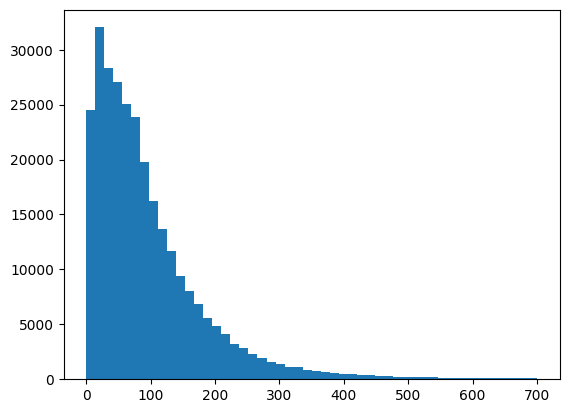

In [ ]:
# Road Length
plt.hist(road_lengths, bins=50, range=(0,700))

In [ ]:
# Compute mean and standard deviation of road length feature for normalization
# in the model
mean =  sum(road_lengths) / len(road_lengths)
stdev = (sum([((x - mean) ** 2) for x in road_lengths]) / len(road_lengths))**(0.5)
print("mean: ", mean, " and stdev: ", stdev)

mean:  102.12144281551696  and stdev:  122.53954082032638


# Lane Count Prediction
We need lane count prediction because it is an important factor in traffic engineering and planning. It can help in determining road capacity, traffic flow, and safety measures. Additionally, accurate lane count information can assist with route planning and navigation for drivers.

### Problem Formulation: Dual Graph

In this section, we'll construct our dataset for lane count prediction. As background on Graph Neural Networks (GNNs), when using GNNs we formulate our task in terms of node classification, link prediction/edge classification, or graph classification. In our dataset, as-is, the level on which we want to make the prediction is edge-level (or road-segment-level). 

We could choose to implement lane count prediction as an edge classification problem, but we're actually going to invert the graph so that road segments become nodes and intersections become edges (where one intersection actually maps to many edges in the new graph). There are two reasons we're choosing to do this inversion:



1.   The [torch_geometric.data.sampler.NeighborSampler](https://pytorch-geometric.readthedocs.io/en/1.6.1/_modules/torch_geometric/data/sampler.html) which is going to subsample our road network into training examples, operates at the node-level. By using node classification, the (BFS) depth for the Neighborhood Sampler directly equals the number of Message-Passing layers in our model.
2.   If we model intersections as nodes, then we won't have very meaningful features for the node embeddings (just degree, centrality, and other synthetic features). The really interesting features (road length, road class) are the edge-level. Edge attributes are supported by some GNN layers (e.g. [GATConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv)) but not others ([GCNConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv)).



In [ ]:
# Function to get attributes [x] and labels [y]
def featureVectorAndLabel(edge_attr):
  featureVector = []

  # Lane Count. -1 is a placeholder for missing or malformed lane count.
  label = -1 if 'lanes' not in edge_attr else edge_attr['lanes']
  try:
    label = int(label) - 1  # 0-index the labels (1 lane = class 0)
  except ValueError:
    label = -1

  # Speed Limit
  maxspeed = -1 if 'maxspeed' not in edge_attr else edge_attr['maxspeed']
  try:
    maxspeed = int(maxspeed.split()[0])
    maxspeed = maxspeed / 100.0  # Normalize
  except:
    maxspeed = -1
  featureVector.append(maxspeed)

  # Road Length
  length = -1 if 'length' not in edge_attr else edge_attr['length']
  try:
    length = float(length)
    # Normalize
    length = (length - 102.12144281551696) / 122.53954082032638
  except ValueError:
    length = -1
  featureVector.append(length)

  # One-Way (originally stored as a bool)
  oneway = -1 if 'oneway' not in edge_attr else edge_attr['oneway']
  if oneway == "True":
    oneway = 1
  else:
    oneway = 0
  featureVector.append(oneway)

  # Road Type
  allowed_road_types = {'motorway': 0, "motorway_link": 1, "primary": 2,
                        "residential": 3, "secondary": 4, "secondary_link": 5,
                        "tertiary": 6, "tertiary_link": 7, "trunk": 8,
                        "trunk_link": 9}
  road_type = -1
  if 'highway' in edge_attr and edge_attr['highway'] in allowed_road_types:
    road_type = allowed_road_types[edge_attr['highway']]
  featureVector.append(road_type)
  return featureVector, label

In [ ]:
# Inverts nodes and edges, so this becomes a node classification problem.
# Each edge in the old graph is a node in the new graph.
# An edge in the new graph gets drawn between any two nodes (road segments)
# which were adjacent (connected by an intersection) in the original graph.
def getDualGraph(originalGraph):
  G = nx.DiGraph()
  for node in originalGraph.nodes:
    incoming_edges = originalGraph.in_edges(node, data=True)
    outgoing_edges = originalGraph.out_edges(node, data=True)

    for (u_incoming, v_incoming, incoming_edge_attr) in incoming_edges: 
      for (u_outgoing, v_outgoing, outgoing_edge_attr) in outgoing_edges:

        new_incoming_node = u_incoming + "-" + v_incoming
        new_outgoing_node = u_outgoing + "-" + v_outgoing

        if new_incoming_node not in G:
          G.add_node(new_incoming_node)
          x, y = featureVectorAndLabel(incoming_edge_attr)
          # x and y are node attributes.
          nx.set_node_attributes(G, {new_incoming_node: {'x': x, 'y': y}})
  
        if new_outgoing_node not in G:
          G.add_node(new_outgoing_node)
          x, y = featureVectorAndLabel(outgoing_edge_attr)
          nx.set_node_attributes(G, {new_outgoing_node: {'x': x, 'y': y}})

        G.add_edge(new_incoming_node, new_outgoing_node)
        original_in_degree = originalGraph.in_degree(node)
        original_out_degree = originalGraph.out_degree(node)
        # edge_attr is the edge attributes (in_degree and out_degree).
        nx.set_edge_attributes(G, {(new_incoming_node, new_outgoing_node): 
        {'edge_attr': [original_in_degree, original_out_degree]}})
  return G

G = getDualGraph(paris)

In [ ]:
# Converts NetworkX graph to torch_geometric.data.Data
data = torch_geometric.utils.convert.from_networkx(G)

In [ ]:
data

Data(x=[285160, 4], edge_index=[2, 693081], edge_attr=[693081, 2], y=[285160])

'x' is the node feature vector, where the 4 attributes correspond to speed limit, road length, one-way, and road class, converted to numeric values. 'y' is the 0-indexed lane count label, where -1 is used as a placeholder value for missing label. Finally 'edge_attr' is the edge feature vector with two features, original graph's in-degree and original graph's out-degree.

In [ ]:
labels = torch.masked_select(data.y, torch.where(data.y >= 0, True, False))

(array([3.0456e+04, 2.6330e+03, 2.3610e+03, 1.6400e+02, 4.4000e+01,
        1.0000e+01, 0.0000e+00, 1.4000e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([ 0.  ,  1.45,  2.9 ,  4.35,  5.8 ,  7.25,  8.7 , 10.15, 11.6 ,
        13.05, 14.5 , 15.95, 17.4 , 18.85, 20.3 , 21.75, 23.2 , 24.65,
        26.1 , 27.55, 29.  ]),
 <BarContainer object of 20 artists>)

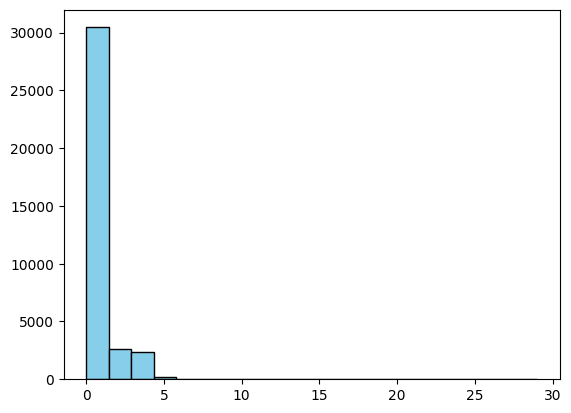

In [ ]:
plt.hist(labels, bins=20, color = 'skyblue', lw=1, ec="black")

In the next few section, we'll use PyTorch's NeighborSampler to create rooted node subgraphs for training.

### Sampling the Graph

The road network is very large, and we need to break it down into smaller pieces for training. The way this is done most commonly in research and industry is to take the K-Hop neighborhood around each node (road segment). For training, we will only construct these rooted subgraphs where we have ground truth (non-negative label). For inference, we'll do this for every single node in the original subgraph.

In [ ]:
# Nodes with lane count label present.
label_mask = torch.where(data.y >= 0, True, False)

In [ ]:
# Use the unique function to get unique values
unique_tensor = torch.unique(labels)

print(unique_tensor)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 11, 29])


In [ ]:
# 35684 total nodes with a label.
torch.sum(label_mask == True)

tensor(35684)

In [ ]:
# Split into Train and Validation (80 / 20)
node_idx = label_mask.nonzero()
num_train = int(0.8 * len(node_idx))
shuffle = torch.randperm(node_idx.size(0))
train_idx = node_idx[shuffle[:num_train]]
val_idx = node_idx[shuffle[num_train:]]

print("Num train: ", len(train_idx))

Num train:  28547


**NeighborSampler Basics**: NeighborSampler samples the K-Hop neighborhood around nodes passed int through `node_idx`. K is specified through the `sizes` argument; each entry in `sizes` corresponds to the number of nodes which should be sampled at the i'th depth where -1 indicates taking all nodes at that depth. Finally, `drop_last` ensures that the number of nodes in the dataset is divisible by the `batch_size`.

In [ ]:
train_loader = NeighborSampler(data.edge_index, node_idx=train_idx,
                               sizes=[-1, -1], batch_size=32,
                               shuffle=True, num_workers=4, drop_last=True)


val_loader = NeighborSampler(data.edge_index, node_idx=val_idx,
                             sizes=[-1, -1], batch_size=32,
                             shuffle=True, num_workers=4, drop_last=True)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let's get a better sense of how many nodes are in each batch. This can give us intuition into how long model training will take. Smaller graphs = faster training, but of course at a cost to accuracy if we think that a larger K-hop radius is more powerful to the model.

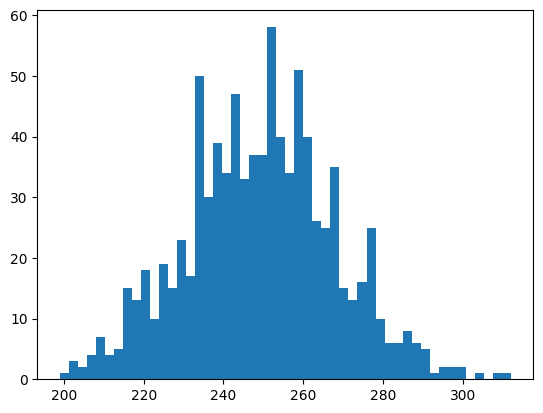

In [ ]:
# Histogram of number of nodes per batch.
num_nodes = []
for _, n_id, _ in train_loader:
  num_nodes.append(len(n_id))
plt.hist(num_nodes, 50)
plt.show()

# Build the Model

In this section, we'll construct the Graph Neural Network using PyTorch Geometric built-in GNN layers. Note that these are more or less plug-and-play layers. 

In [ ]:
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv

# layer_name should be one of:
#   SAGEConv
#   GATConv
class Model(torch.nn.Module):
    def __init__(self, layer_name, input_dim, hidden_dim, output_dim, edge_dim, num_layers, dropout):
        super().__init__()


        # Convolutional Layers
        self.layer_name = layer_name
        layers = []
        if layer_name == "SAGEConv":
          layers = [SAGEConv(input_dim, hidden_dim)]
          for _ in range(num_layers-2):
            layers.append(SAGEConv(hidden_dim, hidden_dim))
          layers.append(SAGEConv(hidden_dim, output_dim))

        elif layer_name == "GATConv":
          layers = [GATConv(input_dim, hidden_dim, edge_dim=edge_dim)]
          for _ in range(num_layers-2):
            layers.append(GATConv(hidden_dim, hidden_dim, edge_dim=edge_dim))
          layers.append(GATConv(hidden_dim, output_dim, edge_dim=edge_dim))
        
        self.convs = torch.nn.ModuleList(layers)

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adjs, edge_attr):
      for i, (edge_index, e_id, size) in enumerate(adjs):
        x_target = x[:size[1]]  # Target nodes are always placed first.
        if self.layer_name == "SAGEConv":
          x = self.convs[i]((x, x_target), edge_index)
        elif self.layer_name == "GATConv":
          x = self.convs[i]((x, x_target), edge_index, edge_attr[e_id])
        if i < len(self.convs) - 1:
          x = F.relu(x)
          x = F.dropout(x, self.dropout, training=self.training)
      return x

## Training and Validation Loops

In [ ]:
# # Returns dictionary of metrics with the following keys:
# # correct: total items predicted correctly
# # TP_k : # of True Positives for Label K
# # FP_k : # of False Positives for Label K
# # FN_k : # of False Negatives for Label K
# def computeMetrics(predicted, actual):
#   metrics = {}
#   metrics['correct'] = int(predicted.eq(actual).sum())
#   num_classes = 11
#   for k in range(num_classes):
#     positive_label = actual.eq(k)
#     negative_label = torch.logical_not(positive_label)
#     positive_prediction = predicted.eq(k) 
#     negative_prediction = torch.logical_not(positive_prediction)

#     TP = float(torch.logical_and(positive_label, positive_prediction).sum())
#     FP = float(torch.logical_and(negative_label, positive_prediction).sum())
#     FN = float(torch.logical_and(positive_label, negative_prediction).sum())

#     metrics['TP_' + str(k)] = TP
#     metrics['FP_' + str(k)] = FP
#     metrics['FN_' + str(k)] = FN
    
#   return metrics

# Returns dictionary of metrics with the following keys:
# correct: total items predicted correctly
# TP_k : # of True Positives for Label K
# FP_k : # of False Positives for Label K
# FN_k : # of False Negatives for Label K
def computeMetrics(predicted, actual):
  metrics = {}
  metrics['correct'] = int(predicted.eq(actual).sum())
  num_classes = 30
  for k in range(num_classes):
    positive_label = actual.eq(k)
    negative_label = torch.logical_not(positive_label)
    positive_prediction = predicted.eq(k) 
    negative_prediction = torch.logical_not(positive_prediction)

    TP = float(torch.logical_and(positive_label, positive_prediction).sum())
    FP = float(torch.logical_and(negative_label, positive_prediction).sum())
    FN = float(torch.logical_and(positive_label, negative_prediction).sum())

    metrics['TP_' + str(k)] = TP
    metrics['FP_' + str(k)] = FP
    metrics['FN_' + str(k)] = FN
    
  return metrics

In [ ]:
# The Train function loops through all batches and computes the loss on the 
# target node.
def train(model, data, train_idx, train_loader, optimizer):
  model.train()
  total_loss = 0
  metrics = defaultdict(float)

  for batch_size, n_id, adjs in train_loader:
    # len(adjs) = number of hops
    adjs = [adj.to(device) for adj in adjs]
    labels = data.y[n_id[:batch_size]]
    optimizer.zero_grad()
    out = model(data.x[n_id].float(), adjs, data.edge_attr.float())
    loss = F.cross_entropy(out, labels)
    loss.backward()
    optimizer.step()
    total_loss += float(loss)
    predictions = out.argmax(dim=-1)
    batch_metrics = computeMetrics(predictions, labels)
    # Bookkeeping
    metrics['total_correct'] += batch_metrics['correct']
    for k in range(7):
      metrics['total_TP_' + str(k)] += batch_metrics['TP_' + str(k)]
      metrics['total_FP_' + str(k)] += batch_metrics['FP_' + str(k)]
      metrics['total_FN_' + str(k)] += batch_metrics['FN_' + str(k)]

  metrics['total_loss'] = total_loss / len(train_loader)
  metrics['accuracy'] = metrics['total_correct'] / train_idx.size(0)
  for k in range(7):
    TP, FP, FN = metrics['total_TP_' + str(k)], metrics['total_FP_' + str(k)], metrics['total_FN_' + str(k)]
    metrics['precision_' + str(k)] = TP/(TP+FP) if TP+FP else 0
    metrics['recall_' + str(k)] = TP/(TP+FN) if TP+FN else 0

  return metrics

In [ ]:
# The Validation function simply runs inference on each node in the validation
# set.
def validate(model, data, val_idx, val_loader):
  total_loss = 0
  metrics = defaultdict(float)

  for batch_size, n_id, adjs in val_loader:
    adjs = [adj.to(device) for adj in adjs]
    out = model(data.x[n_id].float(), adjs, data.edge_attr.float())
    labels = data.y[n_id[:batch_size]]
    predictions = out.argmax(dim=-1)
    loss = F.cross_entropy(out, labels)
    total_loss += float(loss)
    batch_metrics = computeMetrics(predictions, labels)
    # Bookkeeping
    metrics['total_correct'] += batch_metrics['correct']
    for k in range(7):
      metrics['total_TP_' + str(k)] += batch_metrics['TP_' + str(k)]
      metrics['total_FP_' + str(k)] += batch_metrics['FP_' + str(k)]
      metrics['total_FN_' + str(k)] += batch_metrics['FN_' + str(k)]

  metrics['total_loss'] = total_loss / len(val_loader)
  metrics['accuracy'] = metrics['total_correct'] / val_idx.size(0)
  for k in range(7):
    TP, FP, FN = metrics['total_TP_' + str(k)], metrics['total_FP_' + str(k)], metrics['total_FN_' + str(k)]
    metrics['precision_' + str(k)] = TP/(TP+FP) if TP+FP else 0
    metrics['recall_' + str(k)] = TP/(TP+FN) if TP+FN else 0

  return metrics


Now that we've defined the model, and the training and validation functions, we're ready to start training. You'll see 

In [ ]:
!pip install bayesian-optimization --quiet

## SAGEConv Model

### Hyperparameter tuning

In [ ]:
from bayes_opt import BayesianOptimization

# Define the search space for hyperparameters
pbounds = {'hidden_dim': (16, 256),
           'num_layers': (1, 4),
           'dropout': (0, 0.5),
           'lr': (1e-4, 1e-2)}

# Define the function to optimize (in this case, the validation accuracy)
def train_evaluate(hidden_dim, num_layers, dropout, lr):
    # Instantiate the model with the given hyperparameters
    model = Model("SAGEConv", num_features, int(hidden_dim), num_classes, edge_dim, int(num_layers), dropout)

    # Move the model to the device
    model.to(device)

    # Define the optimizer with the given learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train the model for the given number of epochs
    num_epochs = 5
    best_val_accuracy = 0
    for epoch in range(num_epochs):
        train_metrics = train(model, data, train_idx, train_loader, optimizer)
        val_metrics = validate(model, data, val_idx, val_loader)

        # Keep track of the best validation accuracy and save the model if it improves
        if val_metrics['accuracy'] > best_val_accuracy:
            best_val_accuracy = val_metrics['accuracy']
            torch.save(model.state_dict(), 'best_model.pt')

    # Return the best validation accuracy as the objective to optimize
    return best_val_accuracy

# Instantiate the Bayesian optimizer and run the optimization
optimizer = BayesianOptimization(
    f=train_evaluate,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)
optimizer.maximize(init_points=5, n_iter=1)


|   iter    |  target   |  dropout  | hidden... |    lr     | num_la... |
-------------------------------------------------------------------------
| 1         | 0.5972    | 0.2085    | 188.9     | 0.0001011 | 1.907     |
| 2         | 0.6398    | 0.07338   | 38.16     | 0.001944  | 2.037     |
| 3         | 0.564     | 0.1984    | 145.3     | 0.00425   | 3.056     |
| 4         | 0.585     | 0.1022    | 226.7     | 0.0003711 | 3.011     |
| 5         | 0.65      | 0.2087    | 150.1     | 0.00149   | 1.594     |


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


| 6         | 0.6414    | 0.06693   | 150.0     | 0.0005306 | 1.516     |


In [ ]:
# Get the best set of hyperparameters
best_params = optimizer.max['params']
print("Best hyperparameters: ", best_params)

Best hyperparameters:  {'dropout': 0.20865240118356349, 'hidden_dim': 150.0855588269804, 'lr': 0.0014898306920928144, 'num_layers': 1.5943044672546365}


#### Running with best parameters

In [ ]:
device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'

# Hyperparameters
hidden_dim = 150
num_layers = 2
dropout = 0.0
lr = 0.002
num_epochs = 30

# Dataset Parameters
num_features = 4
num_classes = 30
edge_dim = 2

# Model Instantiation
model = Model("SAGEConv", num_features, hidden_dim, num_classes, edge_dim, num_layers, dropout)
model.to(device)
model.reset_parameters()

# Use Adam optimizer to adapt learning rate.
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


train_metrics_history = defaultdict(list)
val_metrics_history = defaultdict(list)
for epoch in range(1, 1 + num_epochs):
  print("Epoch: ", epoch)
  train_metrics = train(model, data, train_idx, train_loader, optimizer)
  val_metrics = validate(model, data, val_idx, val_loader)
  print("Train Loss: {}, Train Accuracy: {}, Val Loss: {}, Val Accuracy: {}".format(train_metrics['total_loss'], train_metrics['accuracy'], val_metrics['total_loss'], val_metrics['accuracy']))
  for metric_name, metric_value in train_metrics.items():
    train_metrics_history[metric_name].append(metric_value)
  for metric_name, metric_value in val_metrics.items():
    val_metrics_history[metric_name].append(metric_value)

Epoch:  1
Train Loss: 1.003746196828081, Train Accuracy: 0.6185938977826041, Val Loss: 0.9566156345632578, Val Accuracy: 0.6289757601233011
Epoch:  2
Train Loss: 0.9281604062147739, Train Accuracy: 0.6468280379724665, Val Loss: 0.9325385912918723, Val Accuracy: 0.6497127644668629
Epoch:  3
Train Loss: 0.9049027916294576, Train Accuracy: 0.6595789399936947, Val Loss: 0.916942142718576, Val Accuracy: 0.6466302367941712
Epoch:  4
Train Loss: 0.8852419805099077, Train Accuracy: 0.6647984026342523, Val Loss: 0.8992049106033394, Val Accuracy: 0.6651254028303208
Epoch:  5
Train Loss: 0.8737339006544763, Train Accuracy: 0.6738361298910569, Val Loss: 0.8918664123979919, Val Accuracy: 0.6581196581196581
Epoch:  6
Train Loss: 0.8623631806384288, Train Accuracy: 0.6764633761866395, Val Loss: 0.8754733843653726, Val Accuracy: 0.6729718369062632
Epoch:  7
Train Loss: 0.853551264534884, Train Accuracy: 0.6796861316425544, Val Loss: 0.8677273860426762, Val Accuracy: 0.6789967773574331
Epoch:  8
Train 

### Accuracy, loss, precision, recall

#### Train and Validation Loss

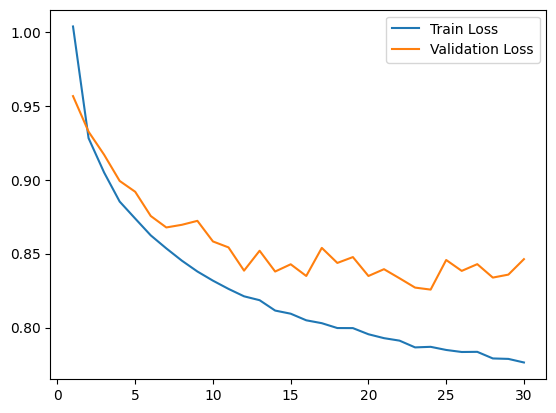

In [ ]:
epochs = range(1, 1+num_epochs)
plt.plot(epochs, train_metrics_history['total_loss'], label = "Train Loss")
plt.plot(epochs, val_metrics_history['total_loss'], label = "Validation Loss")
plt.legend()
plt.show()

### Train and Validation Accuracy

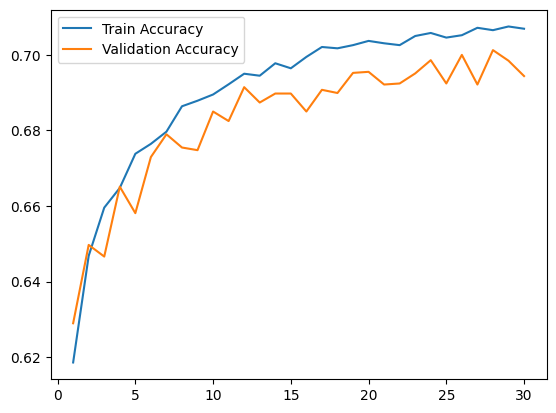

In [ ]:
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_metrics_history['accuracy'], label = "Train Accuracy")
plt.plot(epochs, val_metrics_history['accuracy'], label = "Validation Accuracy")
plt.legend()
plt.show()

#### Precision

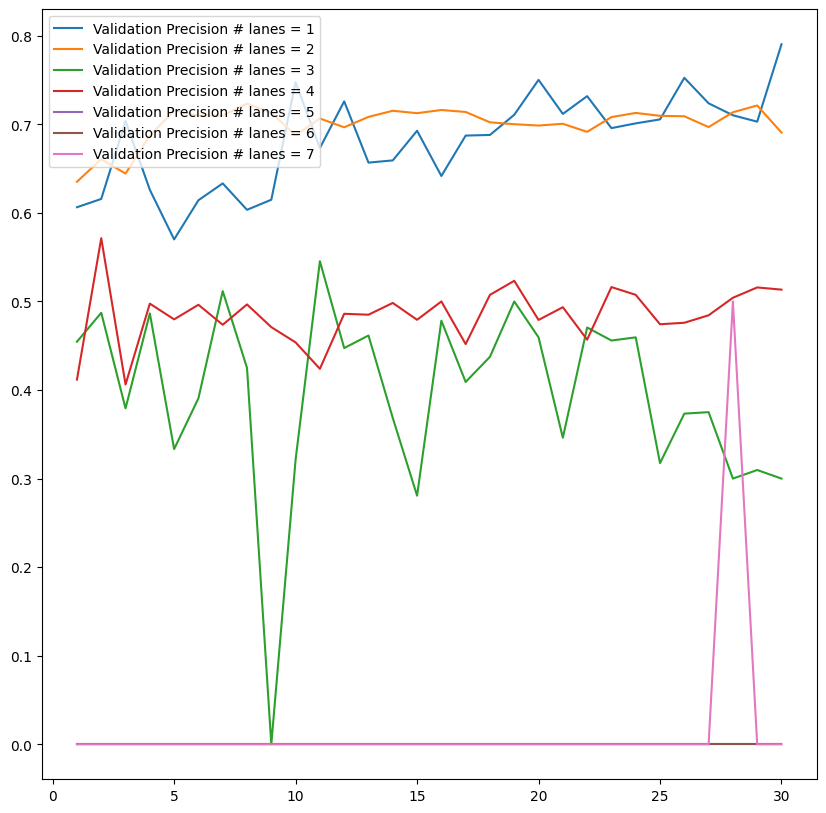

In [ ]:
epochs = range(1, num_epochs+1)
plt.figure(1, figsize=(10, 10))
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
for k in range(10):
    #plt.plot(epochs, train_metrics_history['precision_' + str(k)], label = "Train Precision # lanes = {}".format(k+1))
    try:
      plt.plot(epochs, val_metrics_history['precision_' + str(k)], label = "Validation Precision # lanes = {}".format(k+1))
    except:
      pass
plt.legend()
plt.show()

#### Recall

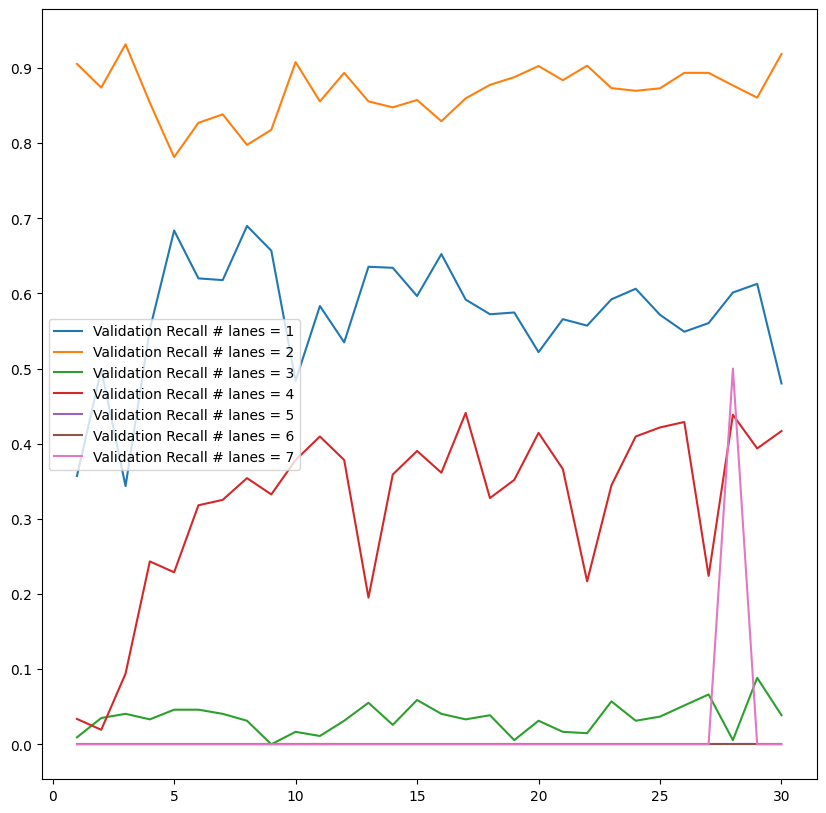

In [ ]:
epochs = range(1, num_epochs+1)
plt.figure(1, figsize=(10, 10))
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
for k in range(30):
  #plt.plot(epochs, train_metrics_history['recall_' + str(k)], label = "Train Recall # lanes = {}".format(k+1))
  try:
    plt.plot(epochs, val_metrics_history['recall_' + str(k)], label = "Validation Recall # lanes = {}".format(k+1))
  except:
    pass
plt.legend()
plt.show()

## Baseline Model - Normal Deep Neural Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.dropout = 0.2
        self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 30),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.stack(x)
        x = F.dropout(logits, self.dropout, training=self.training)
        return x

In [ ]:
neural_network = NeuralNetwork().to(device)
print(neural_network)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (stack): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=30, bias=True)
  )
)


In [ ]:
# Train
def nn_train(model, data, train_idx, optimizer, batch_size):
  model.train()
  total_loss = 0
  metrics = defaultdict(float)

  num_steps = len(train_idx) // batch_size

  for _ in range(num_steps):

    perm = torch.randperm(train_idx.size(0))
    indices = perm[:batch_size]
    batch_idx = train_idx[indices]
 
    labels = torch.squeeze(data.y[batch_idx])
    optimizer.zero_grad()
    out = model(data.x[batch_idx].float())
    loss = F.cross_entropy(out, labels)
    loss.backward()
    optimizer.step()
    total_loss += float(loss)

    prediction = out.argmax(dim=-1)
    batch_metrics = computeMetrics(prediction, labels)

    # Bookkeeping
    metrics['total_correct'] += batch_metrics['correct']
    for k in range(30):
      try:
        metrics['total_TP_' + str(k)] += batch_metrics['TP_' + str(k)]
        metrics['total_FP_' + str(k)] += batch_metrics['FP_' + str(k)]
        metrics['total_FN_' + str(k)] += batch_metrics['FN_' + str(k)]
      except:
        pass

  metrics['total_loss'] = total_loss / num_steps
  metrics['accuracy'] = metrics['total_correct'] / len(train_idx)
  for k in range(30):
    try:
      TP, FP, FN = metrics['total_TP_' + str(k)], metrics['total_FP_' + str(k)], metrics['total_FN_' + str(k)]
      metrics['precision_' + str(k)] = TP/(TP+FP) if TP+FP else 0
      metrics['recall_' + str(k)] = TP/(TP+FN) if TP+FN else 0
    except:
      pass

  return metrics

In [ ]:
from sklearn.utils.fixes import parse_version
# Validation
def nn_validate(model, data, val_idx, batch_size):
  total_loss = 0
  metrics = defaultdict(float)

  num_steps = len(val_idx) // batch_size

  for _ in range(num_steps):

    perm = torch.randperm(val_idx.size(0))
    indices = perm[:batch_size]
    batch_idx = val_idx[indices]
 
    labels = torch.squeeze(data.y[batch_idx])
    out = model(data.x[batch_idx].float())
    loss = F.cross_entropy(out, labels)
    total_loss += float(loss)

    prediction = out.argmax(dim=-1)
    batch_metrics = computeMetrics(prediction, labels)

    # Bookkeeping
    metrics['total_correct'] += batch_metrics['correct']
    for k in range(30):
      try:
        metrics['total_TP_' + str(k)] += batch_metrics['TP_' + str(k)]
        metrics['total_FP_' + str(k)] += batch_metrics['FP_' + str(k)]
        metrics['total_FN_' + str(k)] += batch_metrics['FN_' + str(k)]
      except:
        pass

  metrics['total_loss'] = total_loss / num_steps
  metrics['accuracy'] = metrics['total_correct'] / len(val_idx)
  for k in range(30):
    try:
      TP, FP, FN = metrics['total_TP_' + str(k)], metrics['total_FP_' + str(k)], metrics['total_FN_' + str(k)]
      metrics['precision_' + str(k)] = TP/(TP+FP) if TP+FP else 0
      metrics['recall_' + str(k)] = TP/(TP+FN) if TP+FN else 0
    except:
      pass

  return metrics

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


nn_lr = 0.02
nn_num_epochs = 15
batch_size = 32

# Model Instantiation
nn_model = NeuralNetwork()
nn_model.to(device)

# Use Adam optimizer to adapt learning rate.
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=nn_lr)


nn_train_metrics_history = defaultdict(list)
nn_val_metrics_history = defaultdict(list)
for epoch in range(1, 1 + nn_num_epochs):
  print("Epoch: ", epoch)
  nn_train_metrics = nn_train(nn_model, data, train_idx, nn_optimizer, batch_size)  
  nn_val_metrics = nn_validate(nn_model, data, val_idx, batch_size)
  print("Train Loss: {}, Train Accuracy: {}, Val Loss: {}, Val Accuracy: {}".format(nn_train_metrics['total_loss'], nn_train_metrics['accuracy'], nn_val_metrics['total_loss'], nn_val_metrics['accuracy']))
  for metric_name, metric_value in nn_train_metrics.items():
    nn_train_metrics_history[metric_name].append(metric_value)
  for metric_name, metric_value in nn_val_metrics.items():
    nn_val_metrics_history[metric_name].append(metric_value)

Epoch:  1
Train Loss: 1.4211228120353725, Train Accuracy: 0.5353277051879357, Val Loss: 1.4197416326924825, Val Accuracy: 0.5460277427490542
Epoch:  2
Train Loss: 1.3728195475623213, Train Accuracy: 0.5563456755525975, Val Loss: 1.371717449260934, Val Accuracy: 0.5509317640465181
Epoch:  3
Train Loss: 1.3462546129665032, Train Accuracy: 0.5634917854765825, Val Loss: 1.3297283326029243, Val Accuracy: 0.5715286534958666
Epoch:  4
Train Loss: 1.3451997909711615, Train Accuracy: 0.5668196307843206, Val Loss: 1.3762453909412093, Val Accuracy: 0.5526131427770772
Epoch:  5
Train Loss: 1.3407540560570532, Train Accuracy: 0.5705328055487442, Val Loss: 1.3648190244430918, Val Accuracy: 0.567325206669469
Epoch:  6
Train Loss: 1.321434031553867, Train Accuracy: 0.5735103513504046, Val Loss: 1.3351893499827705, Val Accuracy: 0.574471066274345
Epoch:  7
Train Loss: 1.3283452312107042, Train Accuracy: 0.574666339720461, Val Loss: 1.3219229897041491, Val Accuracy: 0.5596188874877399
Epoch:  8
Train Lo

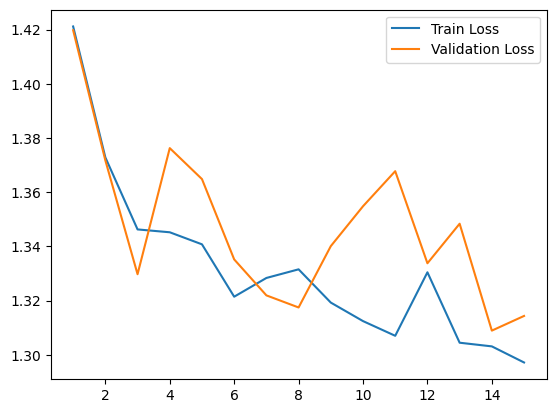

In [ ]:
epochs = range(1, 1+nn_num_epochs)
plt.plot(epochs, nn_train_metrics_history['total_loss'], label = "Train Loss")
plt.plot(epochs, nn_val_metrics_history['total_loss'], label = "Validation Loss")
plt.legend()
plt.show()

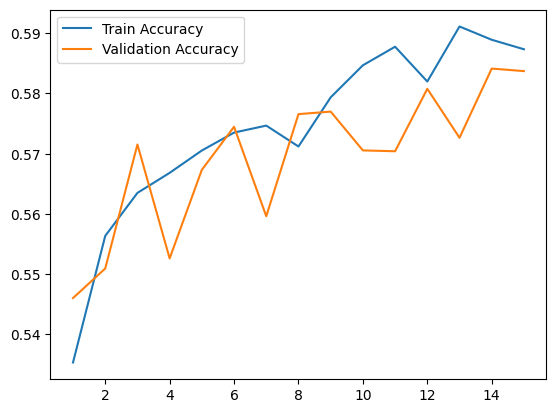

In [ ]:
epochs = range(1, nn_num_epochs+1)
plt.plot(epochs, nn_train_metrics_history['accuracy'], label = "Train Accuracy")
plt.plot(epochs, nn_val_metrics_history['accuracy'], label = "Validation Accuracy")
plt.legend()
plt.show()

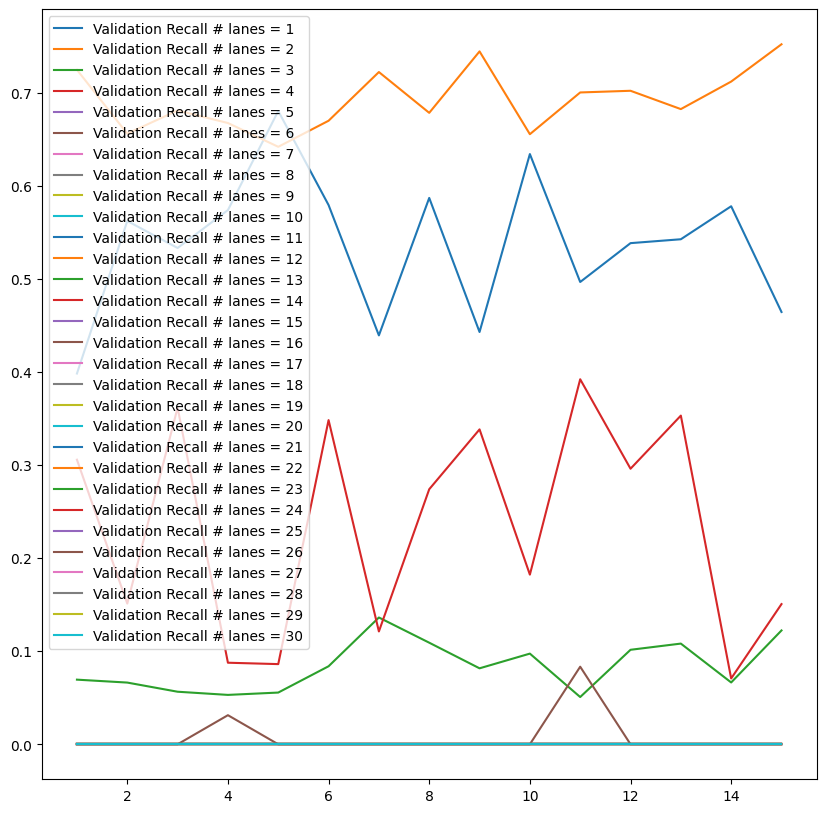

In [ ]:
epochs = range(1, nn_num_epochs+1)
plt.figure(1, figsize=(10, 10))
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
for k in range(30):
  #plt.plot(epochs, nn_train_metrics_history['recall_' + str(k)], label = "Train Recall # lanes = {}".format(k+1))
  try:
    plt.plot(epochs, nn_val_metrics_history['recall_' + str(k)], label = "Validation Recall # lanes = {}".format(k+1))
  except:
    pass
plt.legend()
plt.show()